Model Analysis
--------------------

importing libraries

In [1]:
%matplotlib inline
import json
import os
import time
import numpy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import test_util
import utils
import image_models
import readers
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow import app
from tensorflow import flags
from tensorflow import gfile
from tensorflow import logging
import test
import train

define flags

In [2]:
flags.DEFINE_string("train_dir", "model",
                  "The directory to load the model files from.")
flags.DEFINE_string("model_checkpoint_path", "",
                  "The file to load the model files from. ")
flags.DEFINE_string("output_file", "test.out",
                    "File that contains the csv predictions")
flags.DEFINE_string("test_data_list", None,
                    "List that contains testing data path")
flags.DEFINE_string("test_data_pattern", "test-data/*.tfrecord",
                    "Pattern for testing data path")
flags.DEFINE_integer("image_width", 1918, "Width of the image.")
flags.DEFINE_integer("image_height", 1280, "Height of the image.")
flags.DEFINE_integer("image_channels", 3, "Channels of the image.")

flags.DEFINE_string("model", "BasicUNetModel",
                    "Which architecture to use for the model. Models are defined "
                    "in models.py.")

# Model flags.
flags.DEFINE_integer("batch_size", 4,
                     "How many examples to process per batch for testing.")
flags.DEFINE_float("prediction_threshold", 0.8,
                   "Which value to use as a threshold of true and false values")

# Other flags.
flags.DEFINE_boolean("run_once", False, "Whether to run test only once.")
flags.DEFINE_boolean("half_memory", False, "Whether to run eval with only 45% GPU memory.")
flags.DEFINE_bool("accumulate_gradients", False,
                  "Whether to accumulate gradients of several batches before apply them.")
flags.DEFINE_integer("apply_every_n_batches", 2,
                     "How many batches of gradients to compute before apply them together.")
flags.DEFINE_float(                                                                                 
  "l2_penalty", 1e-7,                                                                             
  "The penalty given to regulization")                                                            
flags.DEFINE_float(                                                                                 
  "regularization_penalty", 1,                                                                    
  "How much weight to give to the regularization loss (the label loss has "                       
  "a weight of 1).")                                                                                                              
flags.DEFINE_float("base_learning_rate", 0.001,                                                     
                 "Which learning rate to start with.")                                            
flags.DEFINE_float("learning_rate_decay", 0.99,                                                     
                 "Learning rate decay factor to be applied every "                                
                 "learning_rate_decay_examples.")                                                 
flags.DEFINE_float("learning_rate_decay_examples", 4000,                                            
                 "Multiply current learning rate by learning_rate_decay "                         
                 "every learning_rate_decay_examples.")                   

function showing pictures and predictions

In [3]:
FLAGS = flags.FLAGS

def show_train_pictures_and_predictions(model_checkpoint_path, data_pattern):
    tf.set_random_seed(0)  # for reproducibility
    with tf.Graph().as_default():
        # convert feature_names and feature_sizes to lists of values
        reader = readers.CarvanaFeatureReader(
                    height=FLAGS.image_height,
                    width=FLAGS.image_width,
                    channels=FLAGS.image_channels)
        model = train.find_class_by_name(FLAGS.model, [image_models])()

        train.build_graph(
            reader=reader,
            model=model,
            train_data_list=None,
            train_data_pattern=data_pattern,
            prediction_threshold=FLAGS.prediction_threshold,
            batch_size=FLAGS.batch_size)

        logging.info("built test graph")

        id_batch = tf.get_collection("id_batch")[0]
        input_batch = tf.get_collection("model_input")[0]
        prediction_batch = tf.get_collection("predictions")[0]
        label_batch = tf.get_collection("labels")[0]
        num_examples = tf.get_collection("num_examples")[0]
        prediction_batch = tf.cast(tf.greater(prediction_batch, FLAGS.prediction_threshold), tf.int32)

        saver = tf.train.Saver(tf.global_variables())
        with tf.Session() as sess:
            saver.restore(sess, model_checkpoint_path)
            sess.run([tf.local_variables_initializer()])

            # Start the queue runners.
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)
            batch_id_val, batch_input_val, batch_prediction_val, batch_label_val = [], [], [], []
            try:
                for i in xrange(4):
                    id_val, input_val, prediction_val, label_val = sess.run([id_batch, input_batch, prediction_batch, label_batch])
                    batch_id_val.append(id_val)
                    batch_input_val.append(input_val)
                    batch_prediction_val.append(prediction_val)
                    batch_label_val.append(label_val)
            except tf.errors.OutOfRangeError:
                print('Done training -- epoch limit reached')
            finally:
                # When done, ask the threads to stop.
                coord.request_stop()

            # Wait for threads to finish.
            coord.join(threads)
            
            id_val = np.concatenate(batch_id_val, axis=0)
            input_val = np.concatenate(batch_input_val, axis=0)
            prediction_val = np.concatenate(batch_prediction_val, axis=0)
            label_val = np.concatenate(batch_label_val, axis=0)
    return id_val, input_val, prediction_val, label_val

In [4]:
FLAGS = flags.FLAGS

def show_pictures_and_predictions(model_checkpoint_path, data_pattern):
    tf.set_random_seed(0)  # for reproducibility
    with tf.Graph().as_default():
        # convert feature_names and feature_sizes to lists of values
        reader = readers.CarvanaTestFeatureReader(
                    height=FLAGS.image_height,
                    width=FLAGS.image_width,
                    channels=FLAGS.image_channels)
        model = test.find_class_by_name(FLAGS.model, [image_models])()

        test.build_graph(
            reader=reader,
            model=model,
            test_data_list=None,
            test_data_pattern=data_pattern,
            prediction_threshold=FLAGS.prediction_threshold,
            batch_size=FLAGS.batch_size)

        logging.info("built test graph")

        id_batch = tf.get_collection("id_batch")[0]
        input_batch = tf.get_collection("input_batch")[0]
        prediction_batch = tf.get_collection("predictions")[0]
        num_examples = tf.get_collection("num_examples")[0]

        saver = tf.train.Saver(tf.global_variables())
        with tf.Session() as sess:
            saver.restore(sess, model_checkpoint_path)
            sess.run([tf.local_variables_initializer()])

            # Start the queue runners.
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)
            batch_id_val, batch_input_val, batch_prediction_val = [], [], []
            try:
                for i in xrange(4):
                    id_val, input_val, prediction_val = sess.run([id_batch, input_batch, prediction_batch])
                    batch_id_val.append(id_val)
                    batch_input_val.append(input_val)
                    batch_prediction_val.append(prediction_val)
            except tf.errors.OutOfRangeError:
                print('Done training -- epoch limit reached')
            finally:
                # When done, ask the threads to stop.
                coord.request_stop()

            # Wait for threads to finish.
            coord.join(threads)
            
            id_val = np.concatenate(batch_id_val, axis=0)
            input_val = np.concatenate(batch_input_val, axis=0)
            prediction_val = np.concatenate(batch_prediction_val, axis=0)
    return id_val, input_val, prediction_val

In [5]:
def show_image(id_val, input_val, prediction_val, label_val=None, figsize=(20,10)):
    num_examples = id_val.shape[0]
    for i in xrange(num_examples):
        # print id_val[i]
        fig = plt.figure(figsize=figsize)
        plt.axis("off")
        if label_val is not None:
            a=fig.add_subplot(1,3,1)
            imgplot = plt.imshow(input_val[i,:,:,:])
            a.set_title('Input')
            a=fig.add_subplot(1,3,2)
            imgplot = plt.imshow(prediction_val[i,:,:])
            a.set_title('Mask')            
            a=fig.add_subplot(1,3,3)
            imgplot = plt.imshow(label_val[i,:,:])
            a.set_title('Label')
        else:
            a=fig.add_subplot(1,2,1)
            imgplot = plt.imshow(input_val[i,:,:,:])
            a.set_title('Input')
            a=fig.add_subplot(1,2,2)
            imgplot = plt.imshow(prediction_val[i,:,:])
            a.set_title('Mask')            
    return None

define model path and test data pattern

In [6]:
model_checkpoint_path = "model/basic_unet_train-1/model.ckpt-10784"
train_data_pattern = "train-data/data-0111.tfrecord"
valid_data_pattern = "train-data/data-0263.tfrecord"
test_data_pattern = "test-data/data-1887.tfrecord"

In-set prediction

In [7]:
%%capture
train_id_val, train_image_val, train_prediction_val, train_mask_val = \
    show_train_pictures_and_predictions(model_checkpoint_path, train_data_pattern)

INFO:tensorflow:Using batch size of 4 for training.
INFO:tensorflow:Number of training files: 1.
INFO:tensorflow:built test graph
INFO:tensorflow:Restoring parameters from model/basic_unet_train-1/model.ckpt-10784


## Predictions on the training set

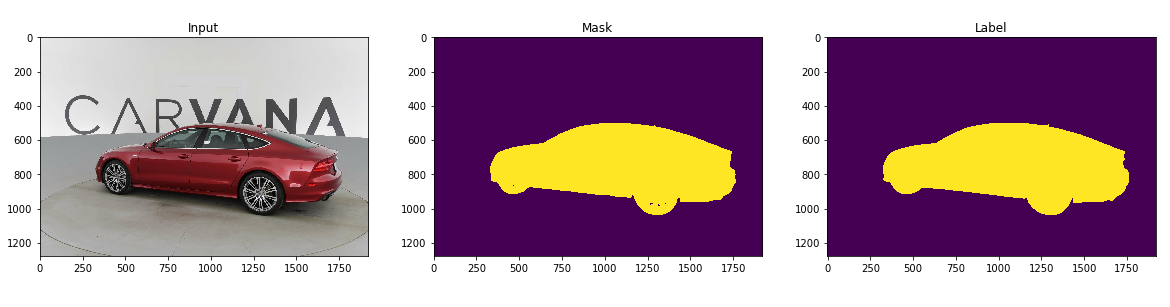

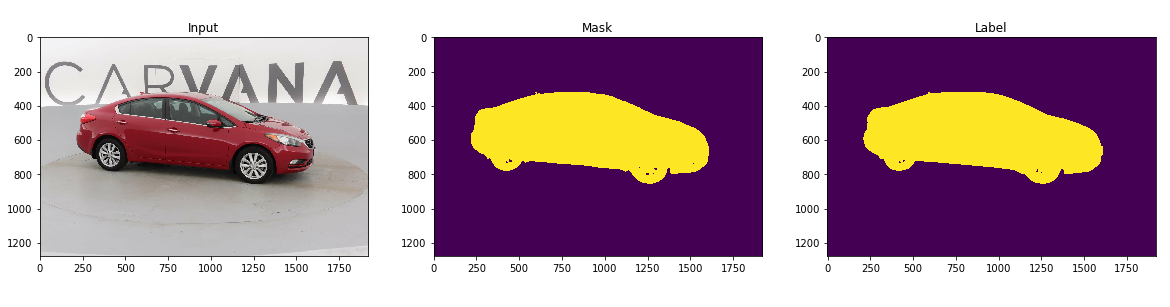

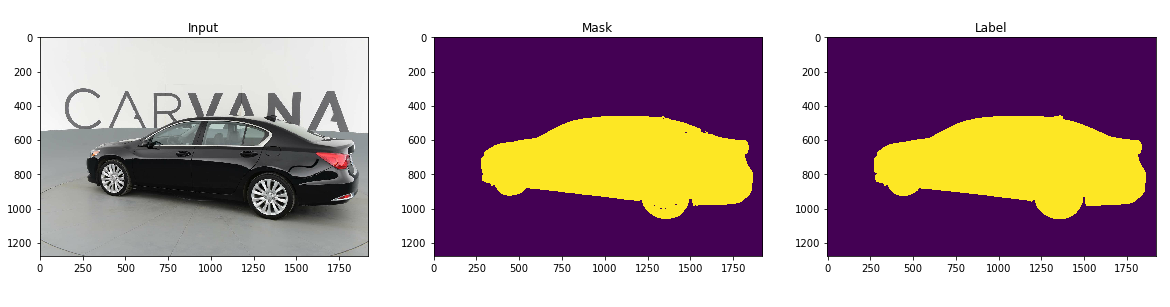

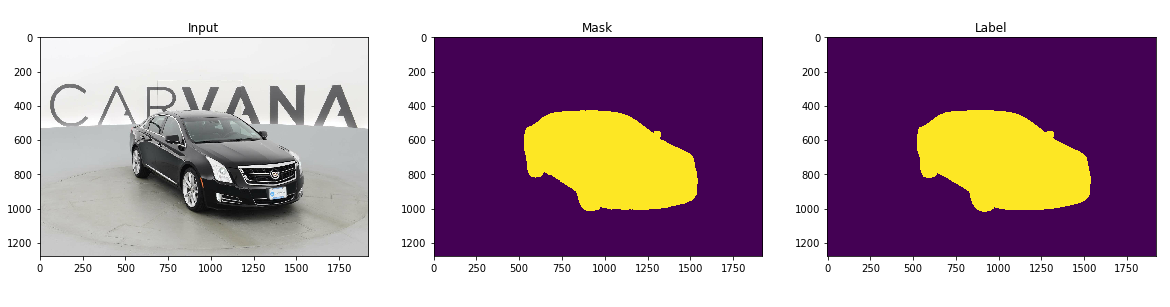

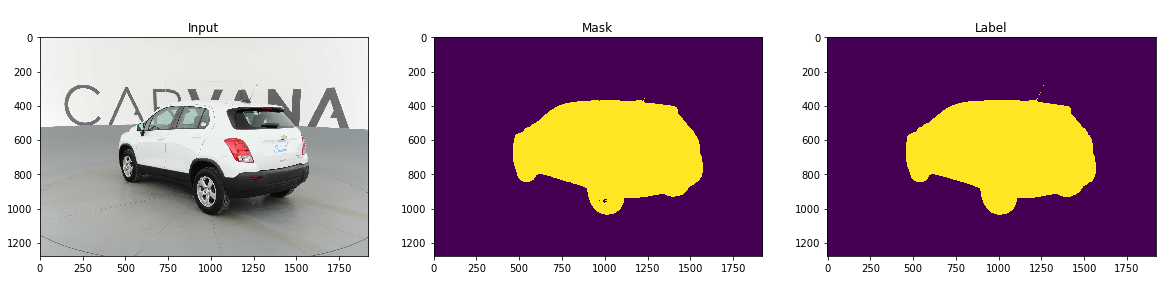

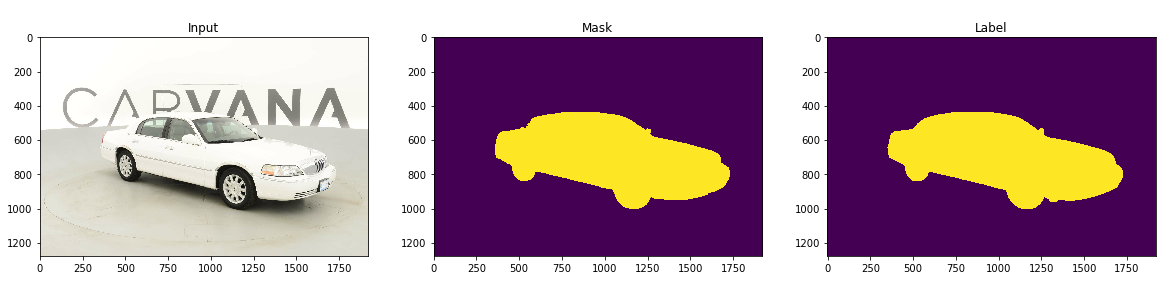

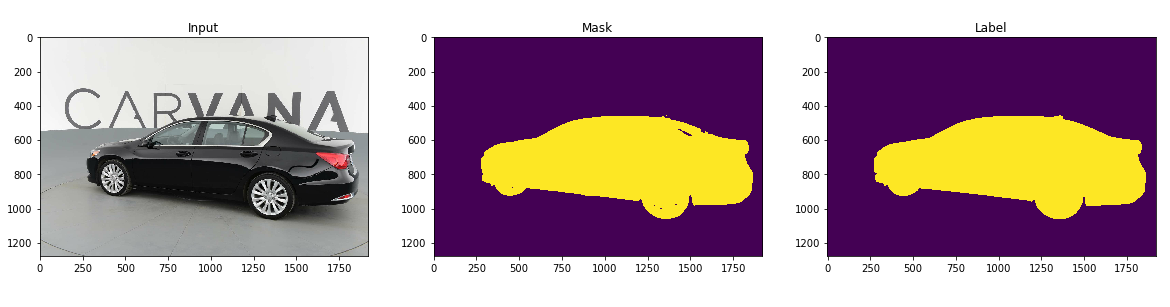

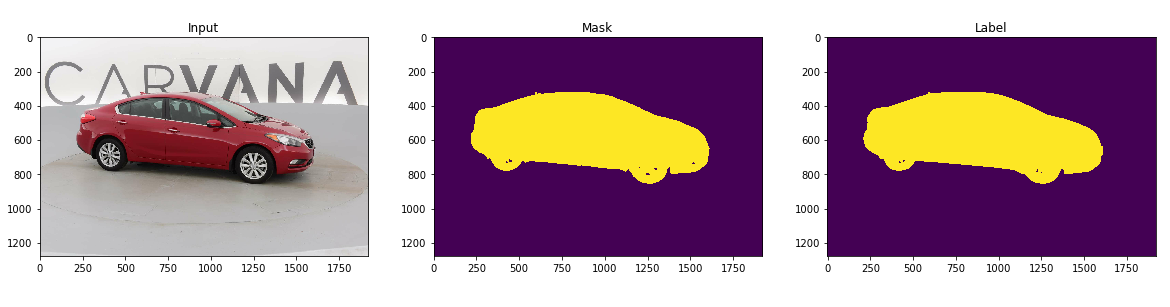

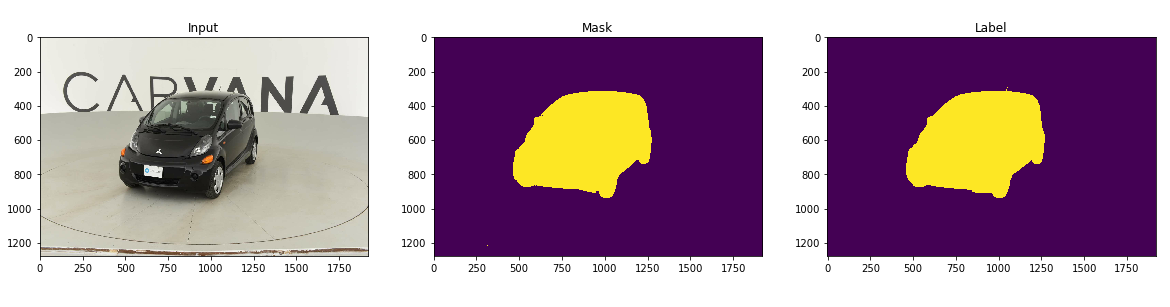

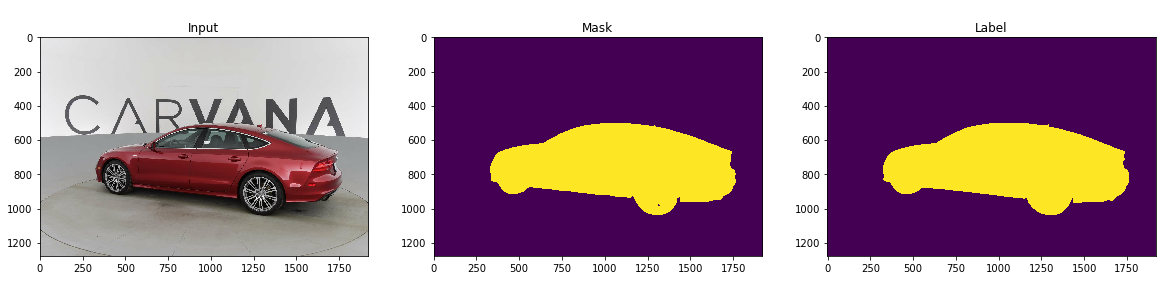

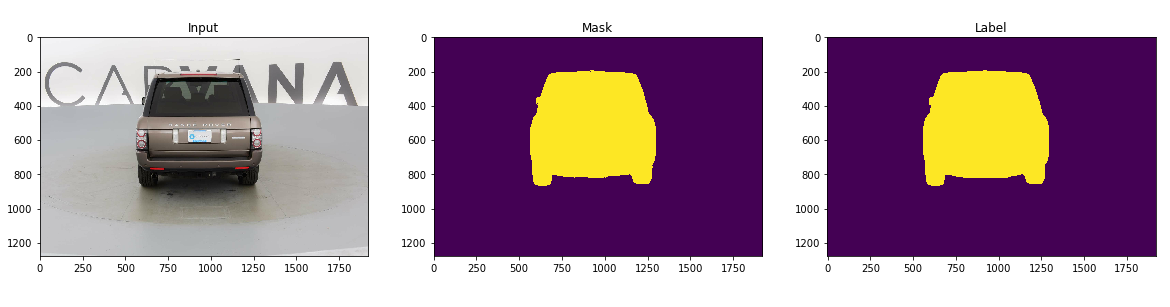

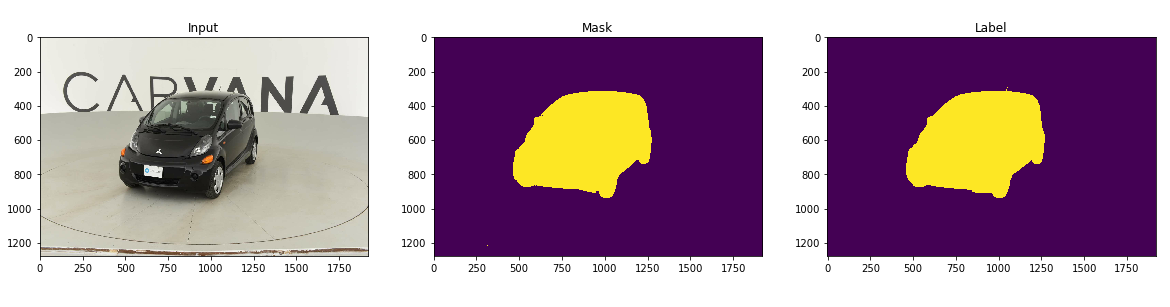

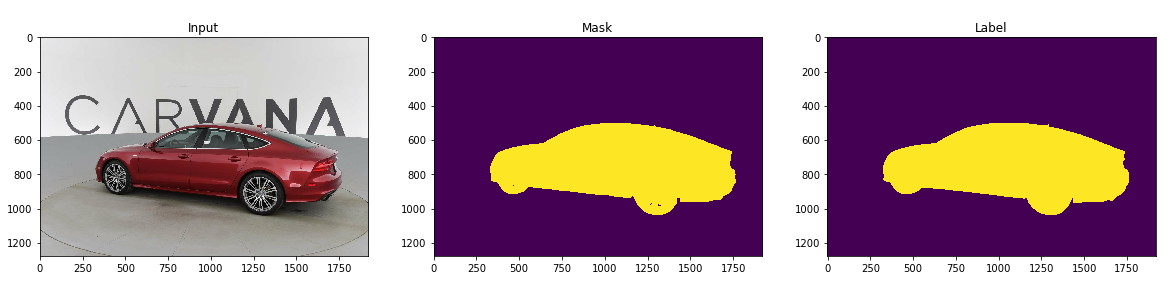

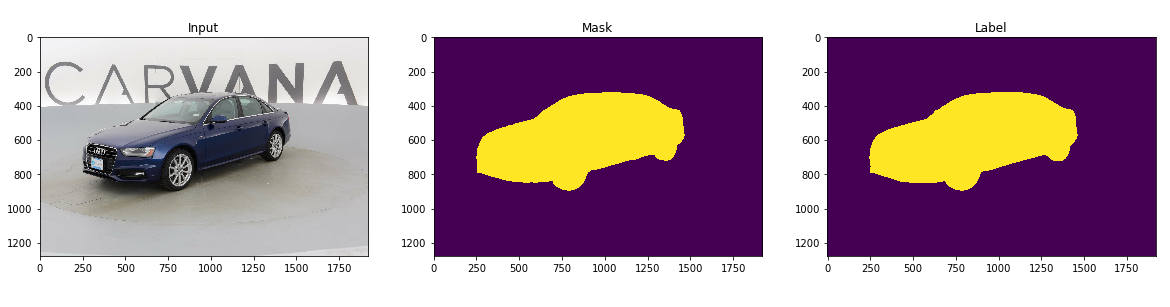

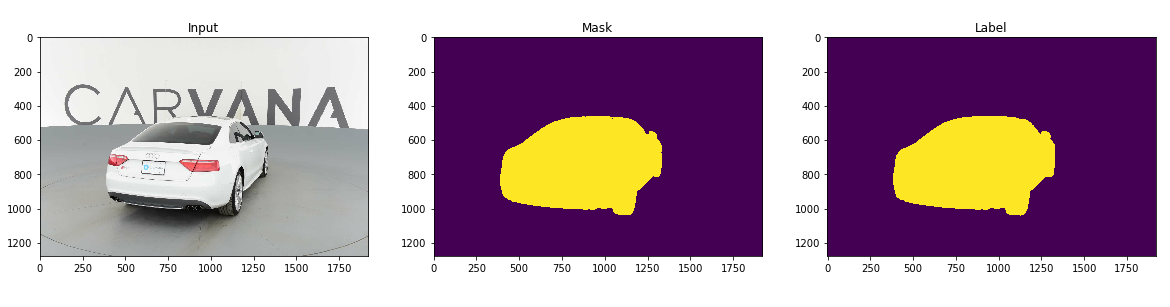

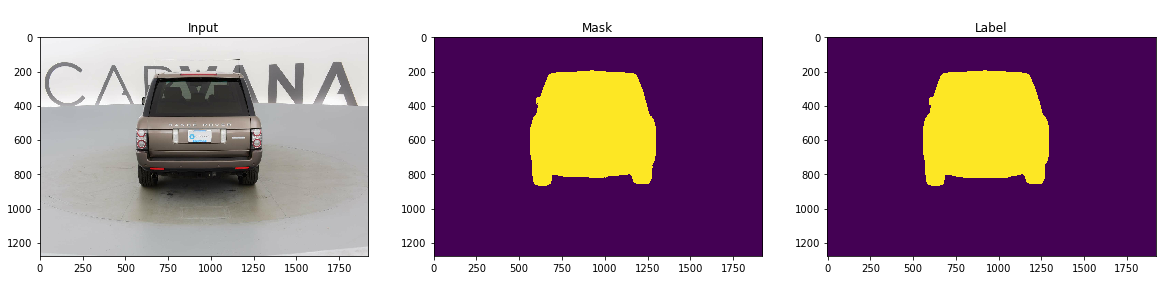

In [8]:
show_image(train_id_val, train_image_val, train_prediction_val, label_val=train_mask_val, figsize=(20,5))

Out-of-set validation prediction

In [9]:
%%capture
valid_id_val, valid_image_val, valid_prediction_val = \
    show_pictures_and_predictions(model_checkpoint_path, valid_data_pattern)

INFO:tensorflow:Using batch size of 4 for test.
INFO:tensorflow:number of test files: 1
INFO:tensorflow:built test graph
INFO:tensorflow:Restoring parameters from model/basic_unet_train-1/model.ckpt-10784


## Predictions on the validation set

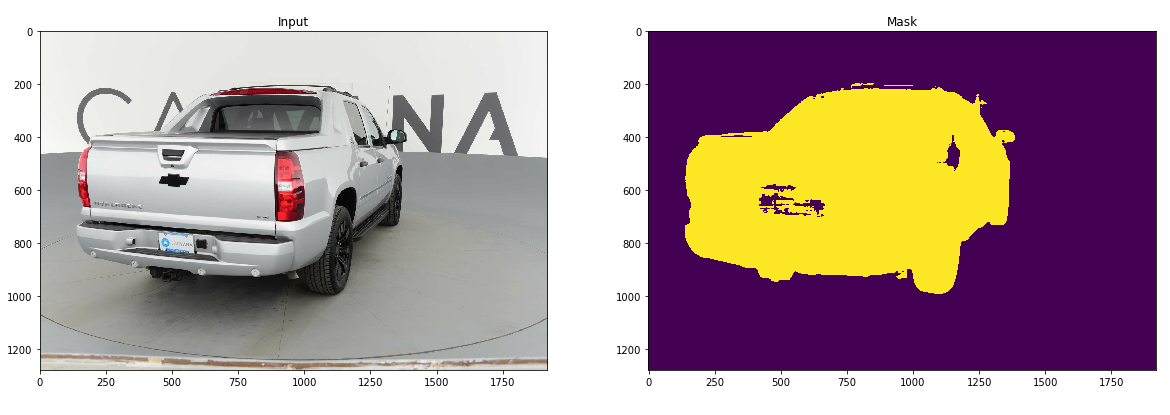

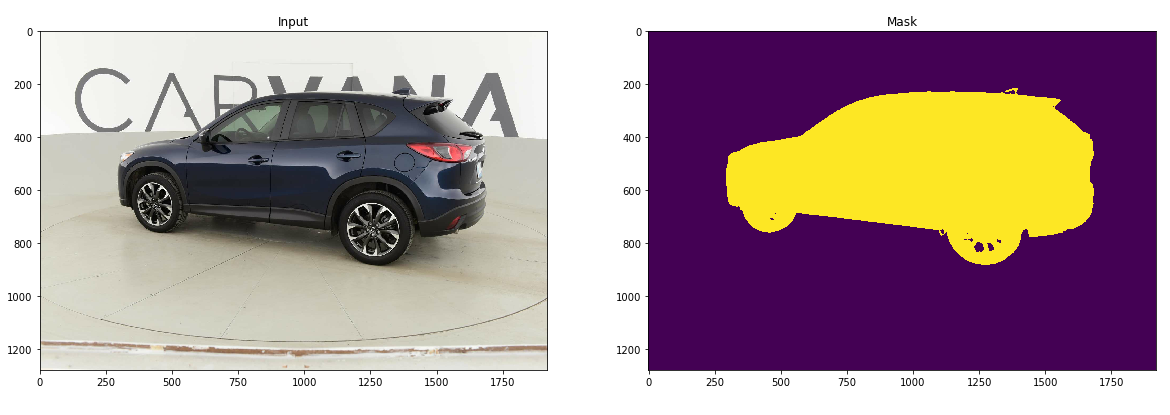

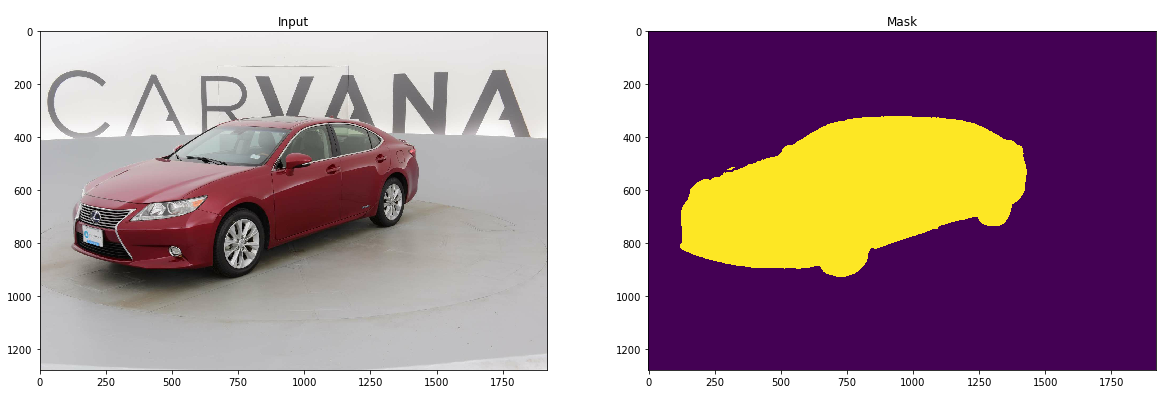

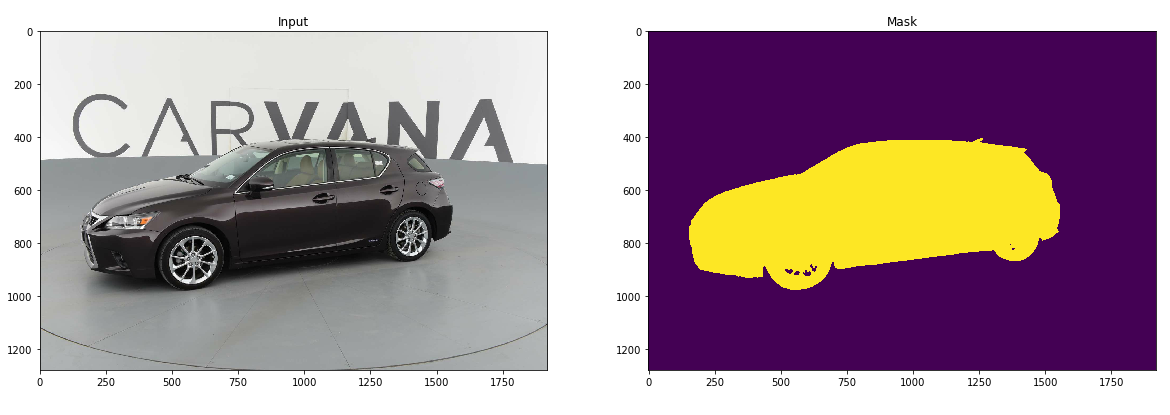

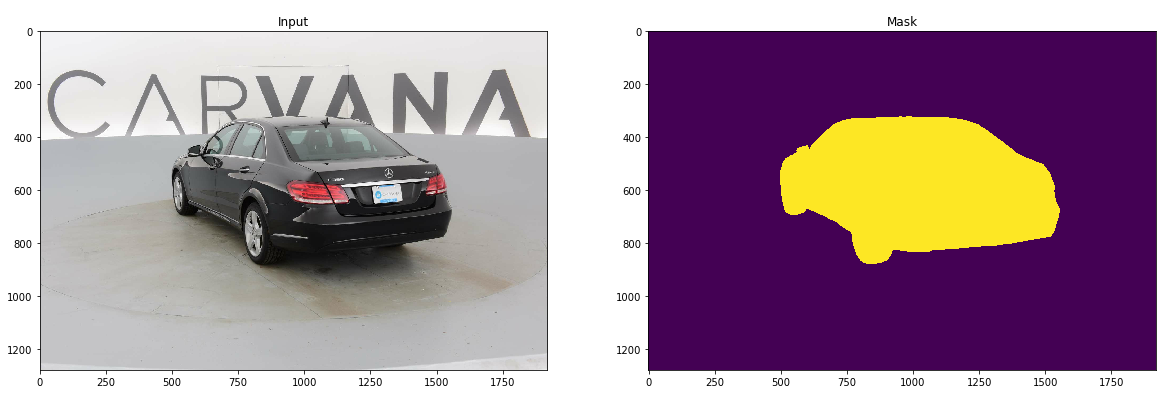

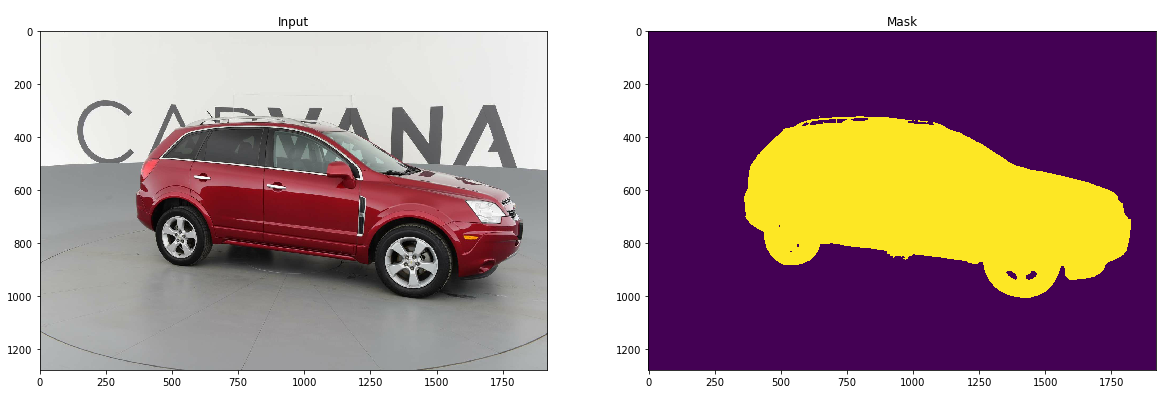

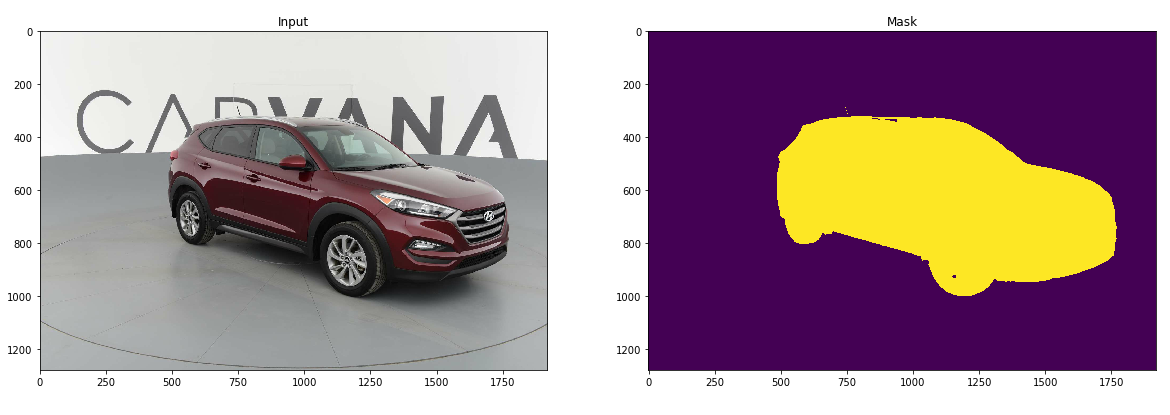

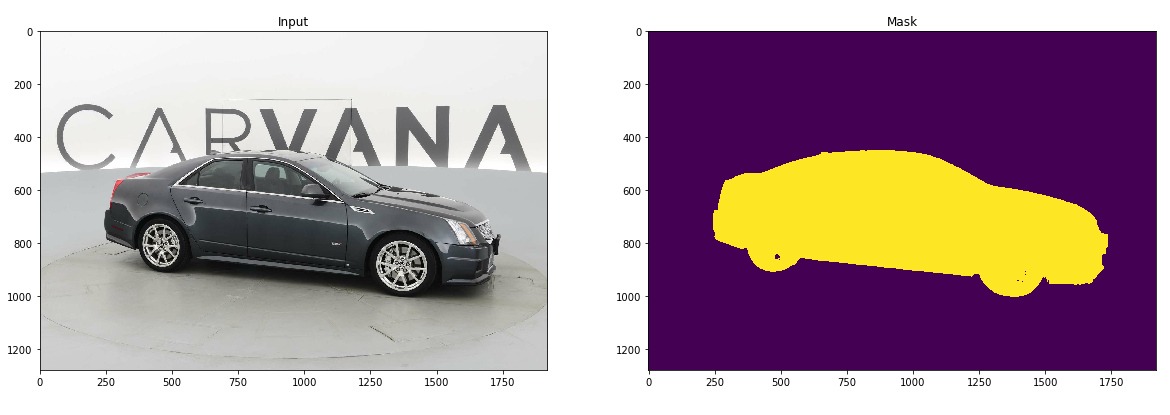

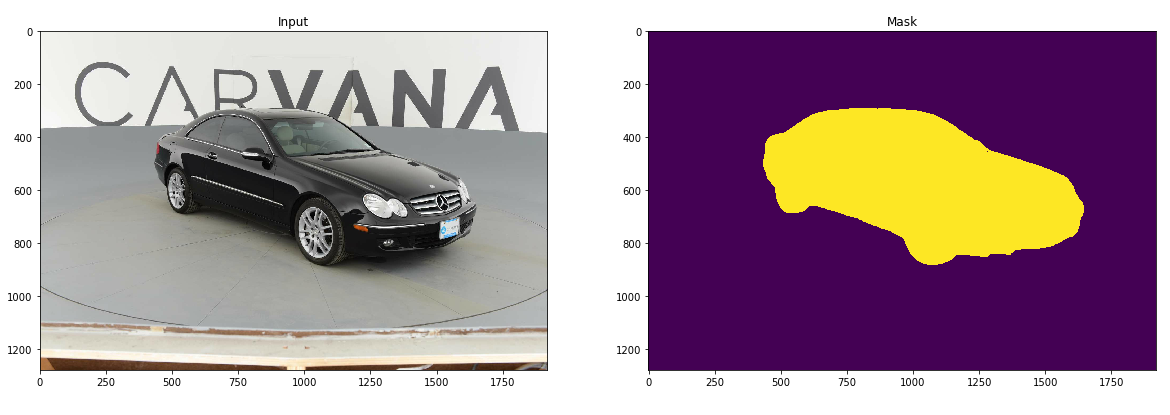

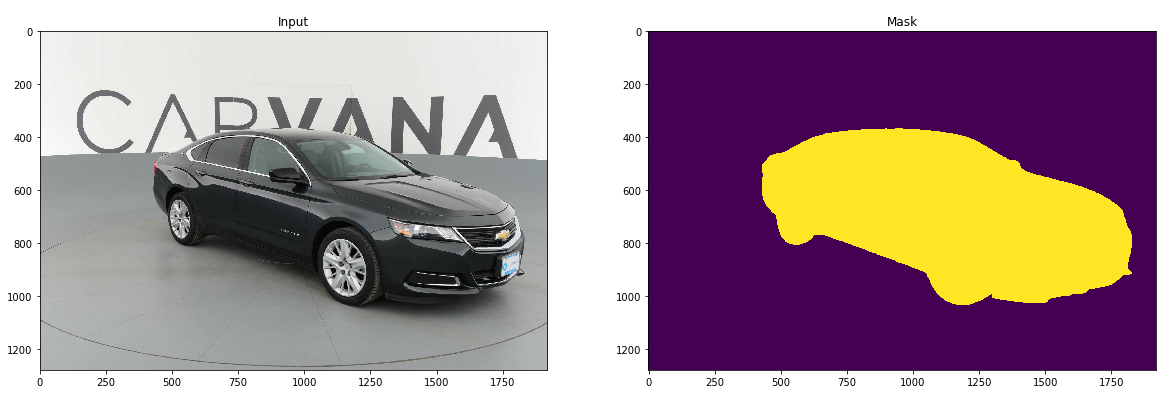

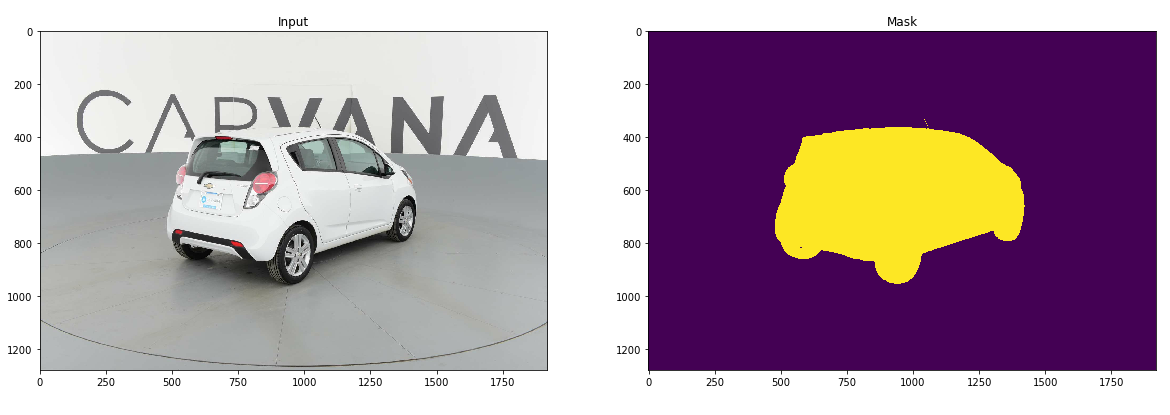

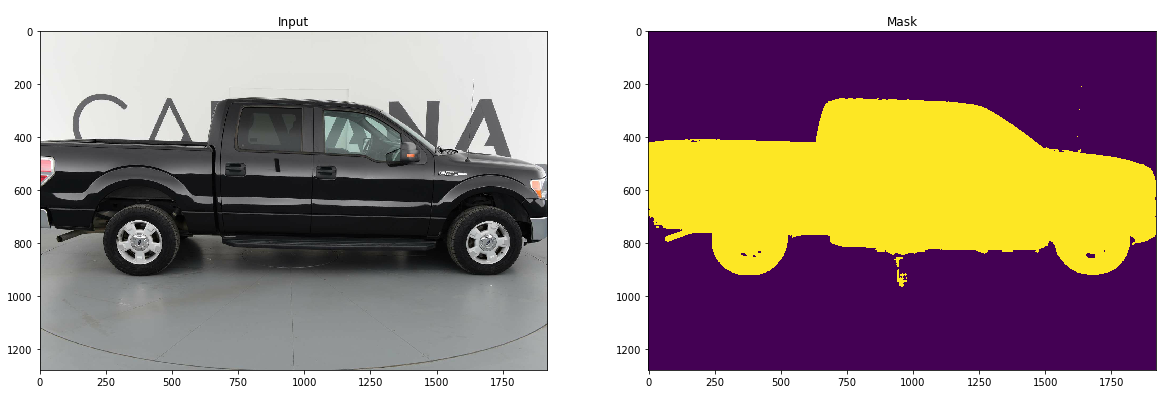

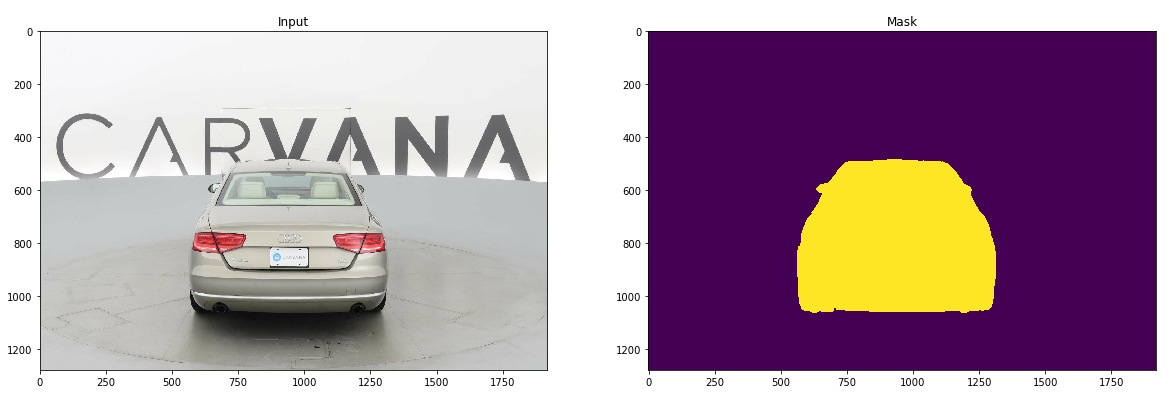

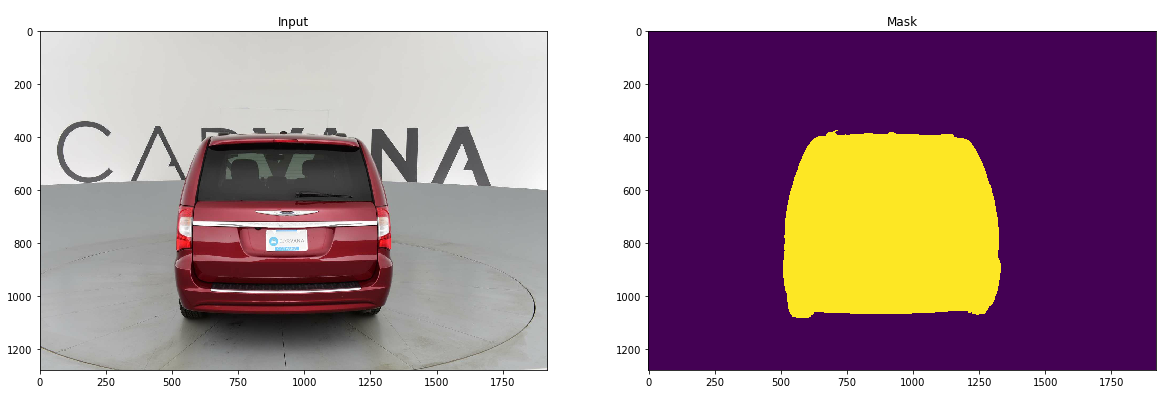

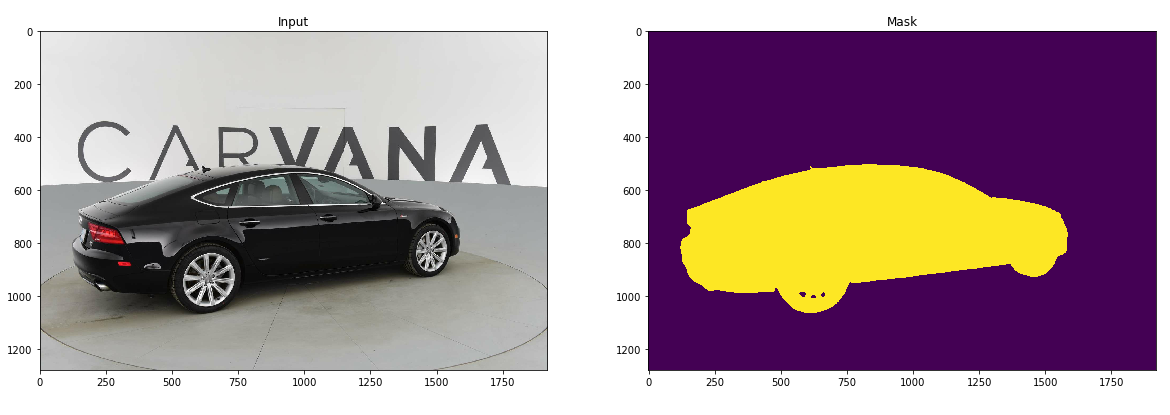

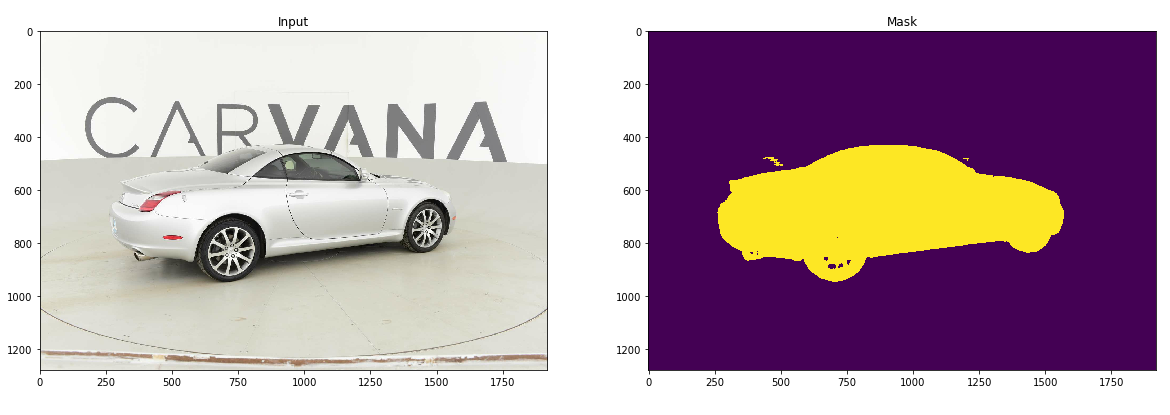

In [10]:
show_image(valid_id_val, valid_image_val, valid_prediction_val, figsize=(20,7))

Out-of-set test prediction

In [11]:
%%capture
test_id_val, test_image_val, test_prediction_val = \
    show_pictures_and_predictions(model_checkpoint_path, test_data_pattern)

INFO:tensorflow:Using batch size of 4 for test.
INFO:tensorflow:number of test files: 1
INFO:tensorflow:built test graph
INFO:tensorflow:Restoring parameters from model/basic_unet_train-1/model.ckpt-10784


## Predictions on the testing set

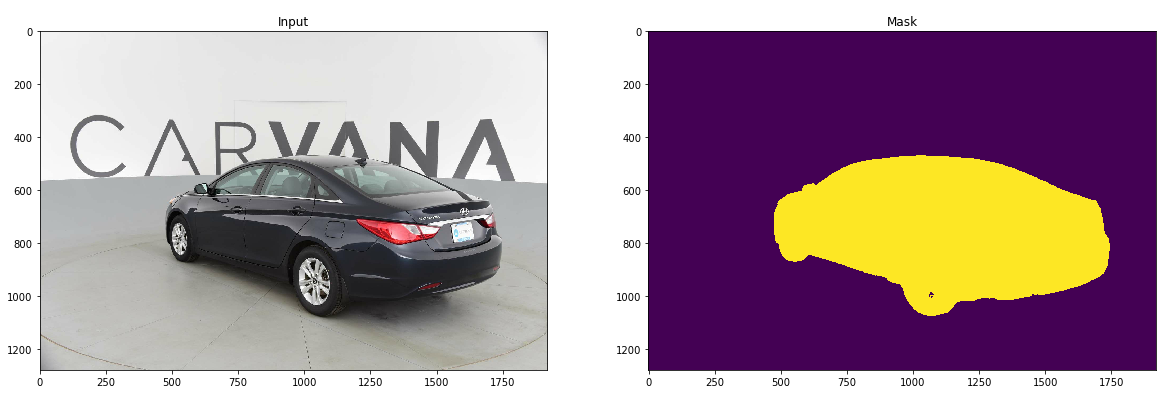

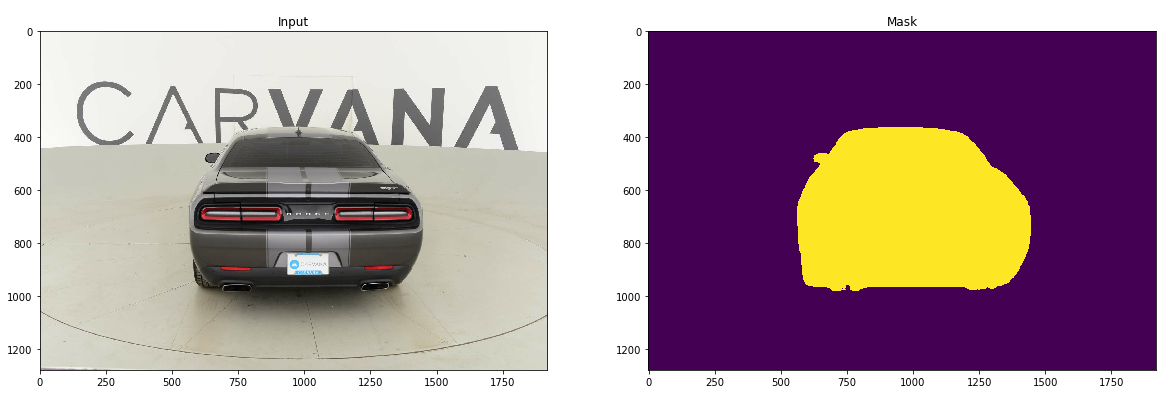

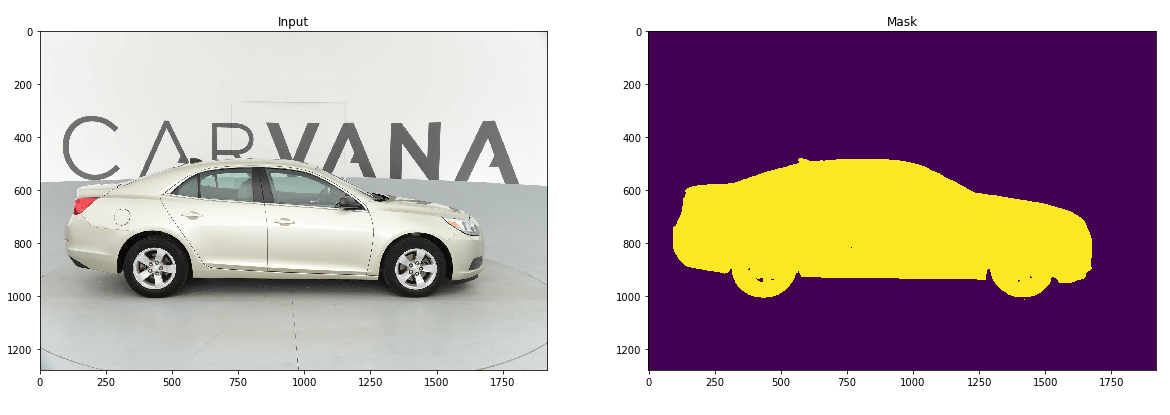

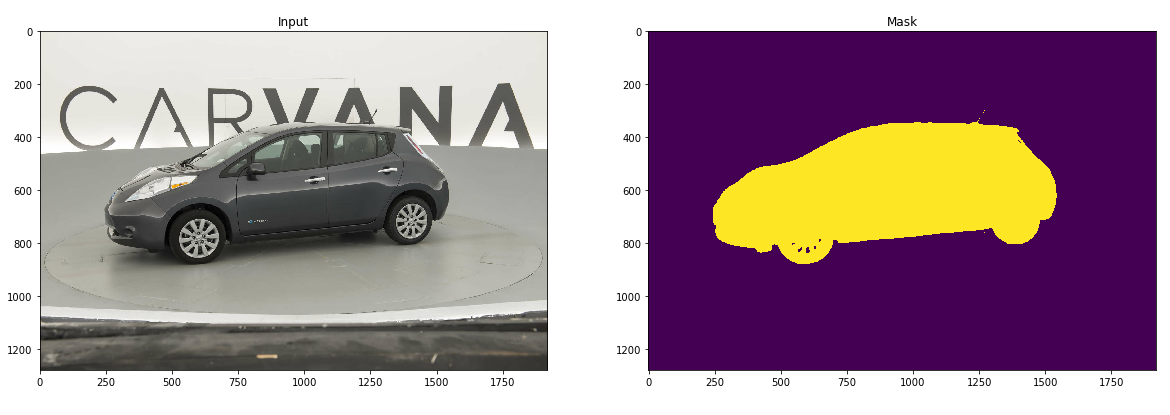

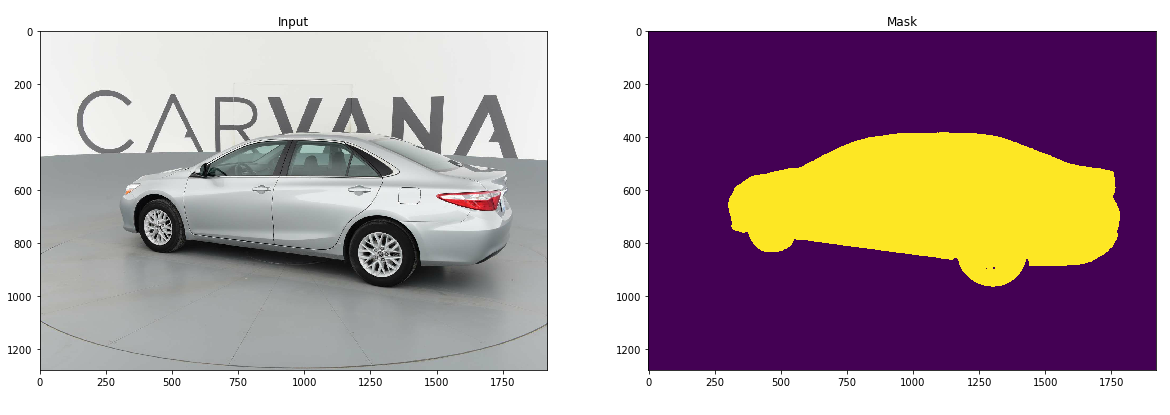

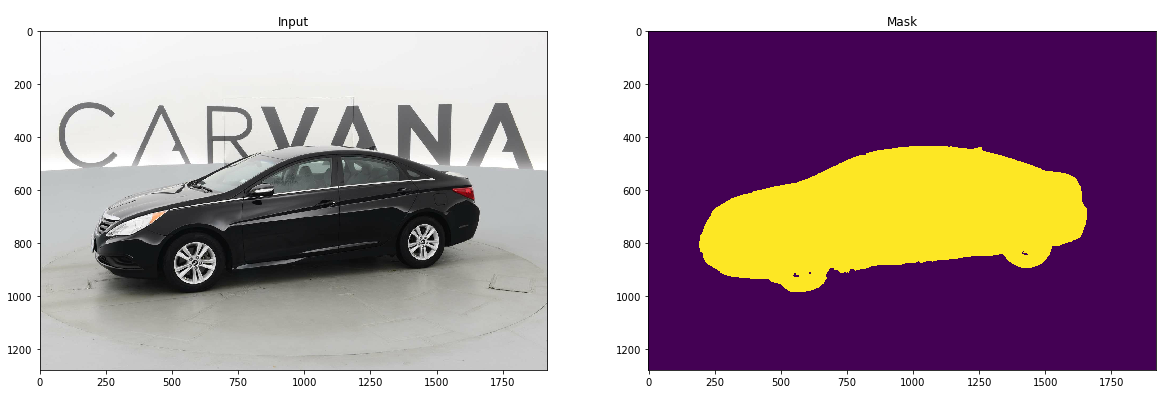

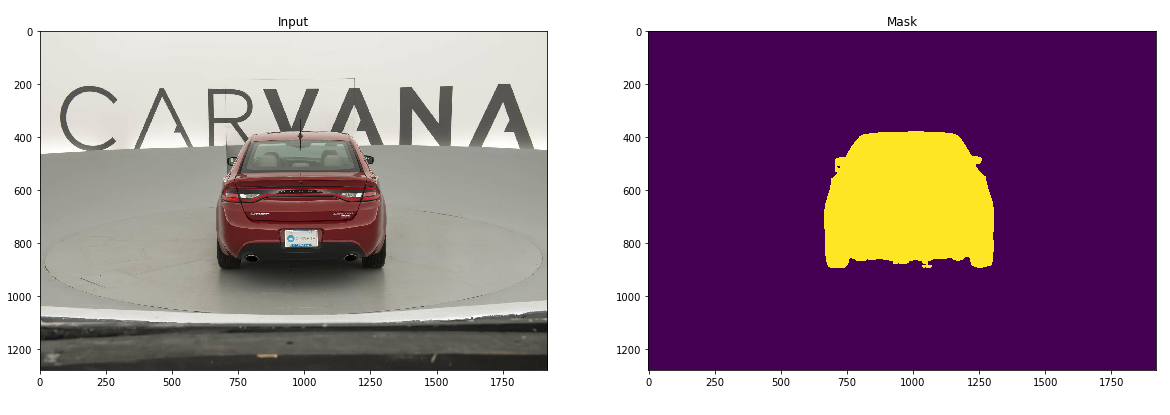

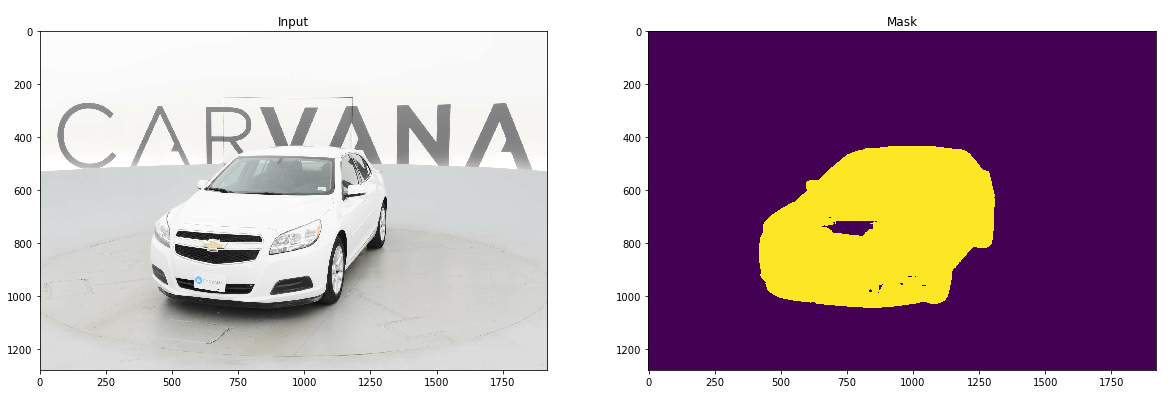

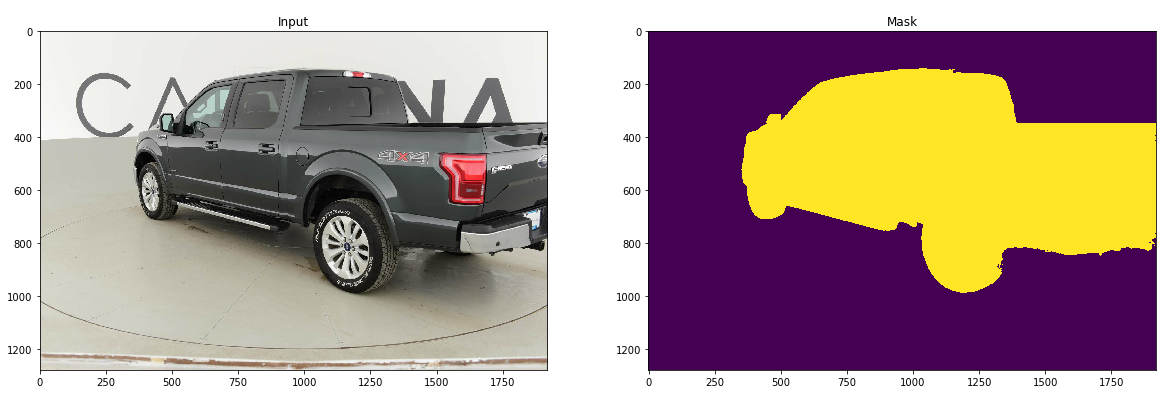

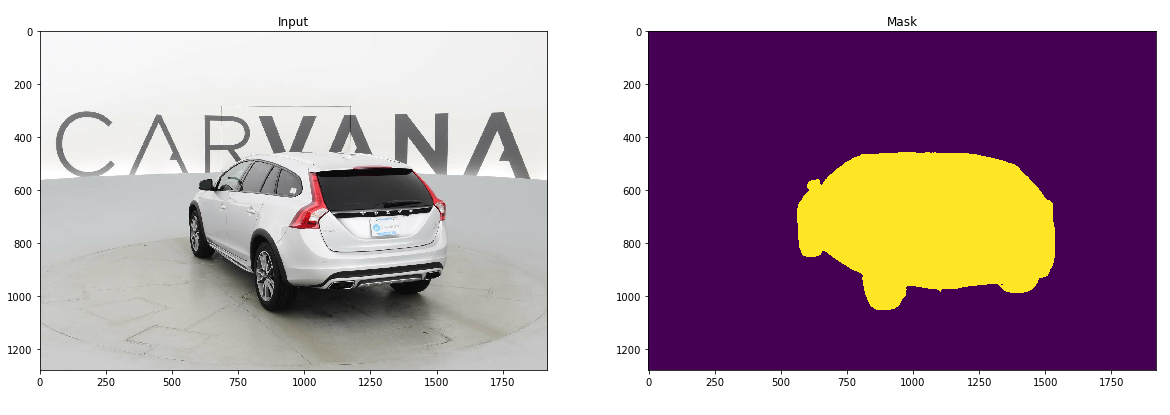

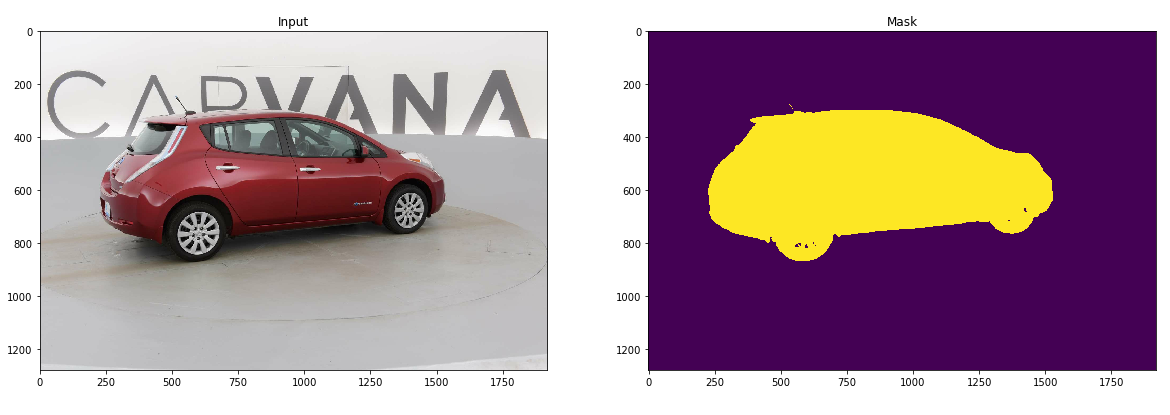

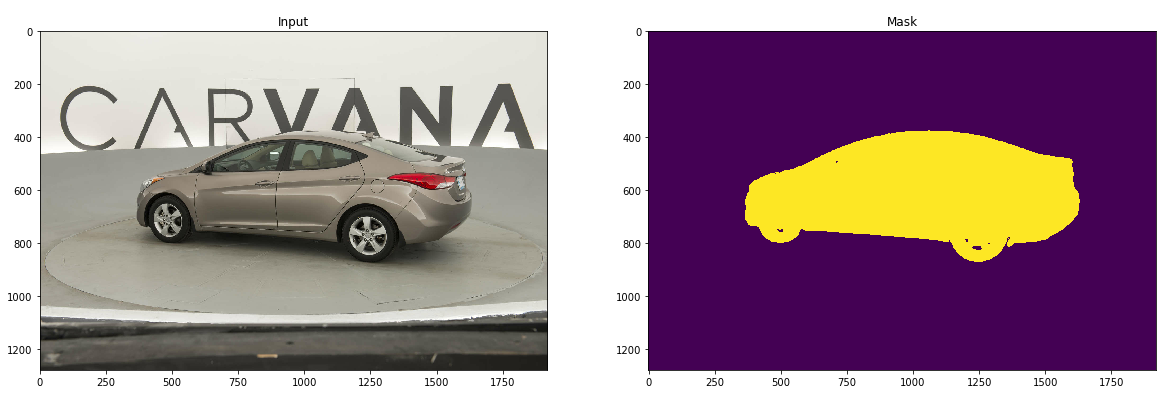

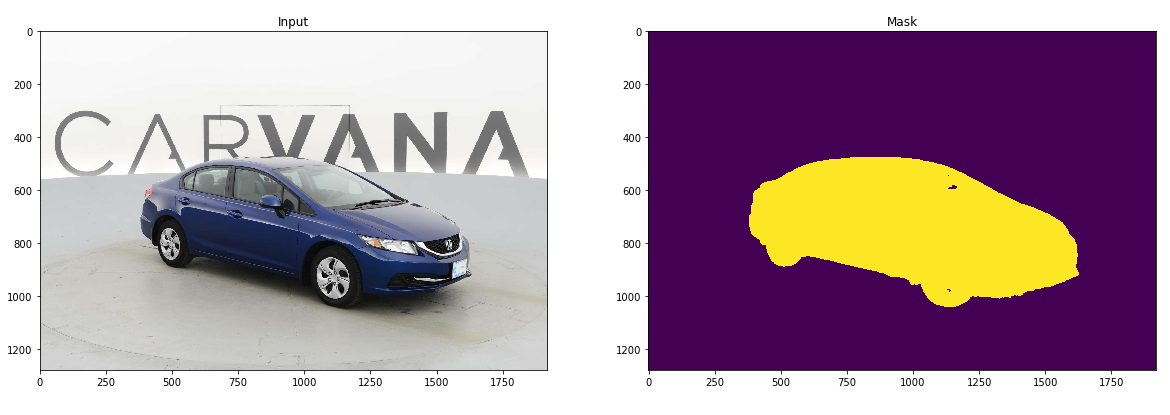

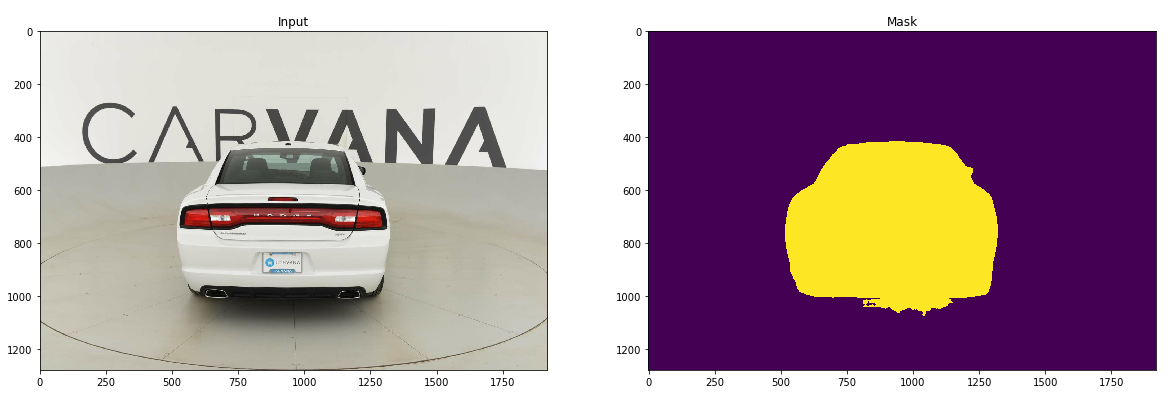

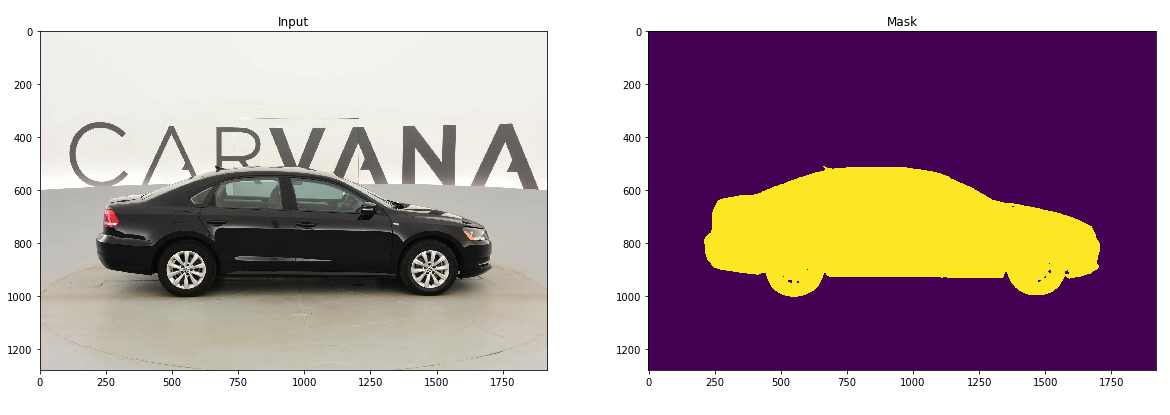

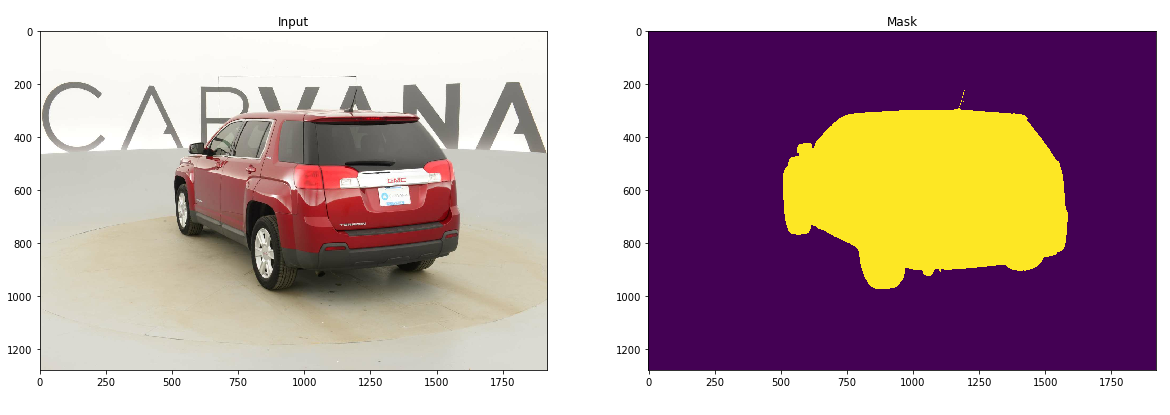

In [12]:
show_image(test_id_val, test_image_val, test_prediction_val, figsize=(20,7))